# Library

In [1]:
# Basics
import io
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
import random
import numpy as np
import pandas as pd
import zipfile
from google.colab import drive
from tqdm import tqdm

# Visuals
import seaborn as sns
from PIL import Image
import cv2
from matplotlib.image import imread
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Data extraction

Beforehand, you'll need to download the dataset. For this notebook, I utilized the dataset from Kaggle, which can be found here: https://www.kaggle.com/c/dogs-vs-cats/data

## Mount

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


## Unzip

In [3]:
train_path = "/content/drive/MyDrive/Colab Notebooks/Cats_vs_Dogs/train.zip"
test_path = "/content/drive/MyDrive/Colab Notebooks/Cats_vs_Dogs/test1.zip"

In [4]:
files = "/kaggle/working/"

In [5]:
with zipfile.ZipFile(train_path, 'r') as zipp:
    zipp.extractall(files)

with zipfile.ZipFile(test_path, 'r') as zipp:
    zipp.extractall(files)

## Loading images in a dataframe

In [6]:
image_dir = "/kaggle/working/train"

filenames = os.listdir(image_dir)
labels = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})

data.head()

,filename,label
0,dog.2785.jpg,dog
1,cat.2303.jpg,cat
2,cat.7099.jpg,cat
3,dog.12428.jpg,dog
4,dog.8047.jpg,dog


# Data visualization and train test split


## Data visualization : Dogs

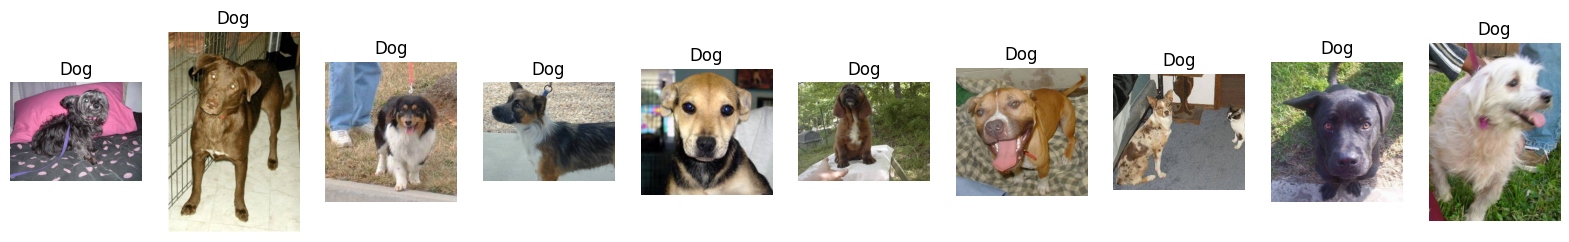

In [7]:
plt.figure(figsize=(20,20)) # Specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(10):

    plt.subplot(1,10,i+1)    # The number of images in the grid is 10*10 (100)
    filename = '/kaggle/working/train/' + 'dog.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Dog',fontsize=12)
    plt.axis('off')

plt.show()

## Data visualization : Cats


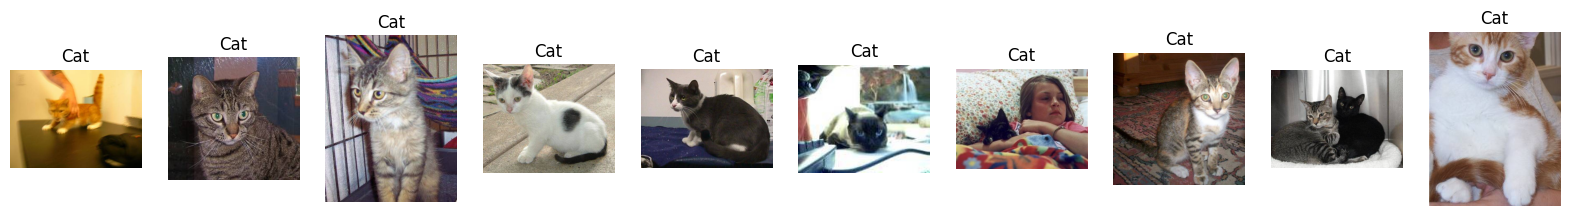

In [8]:
plt.figure(figsize=(20,20)) # Specifying the overall grid size
plt.subplots_adjust(hspace=0.4)


for i in range(10):

    plt.subplot(1,10,i+1) # The number of images in the grid is 10*10 (100)
    filename = '/kaggle/working/train/' + 'cat.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Cat',fontsize=12)
    plt.axis('off')

plt.show()

## Train test split


In [9]:
# Train test split using dataframe

labels = data['label']

X_train, X_temp = train_test_split(data, test_size=0.2, stratify=labels, random_state = 23)

label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 23)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (20000, 2)
The shape of test data (2500, 2)
The shape of validation data (2500, 2)


## Data visualization : Class distribution

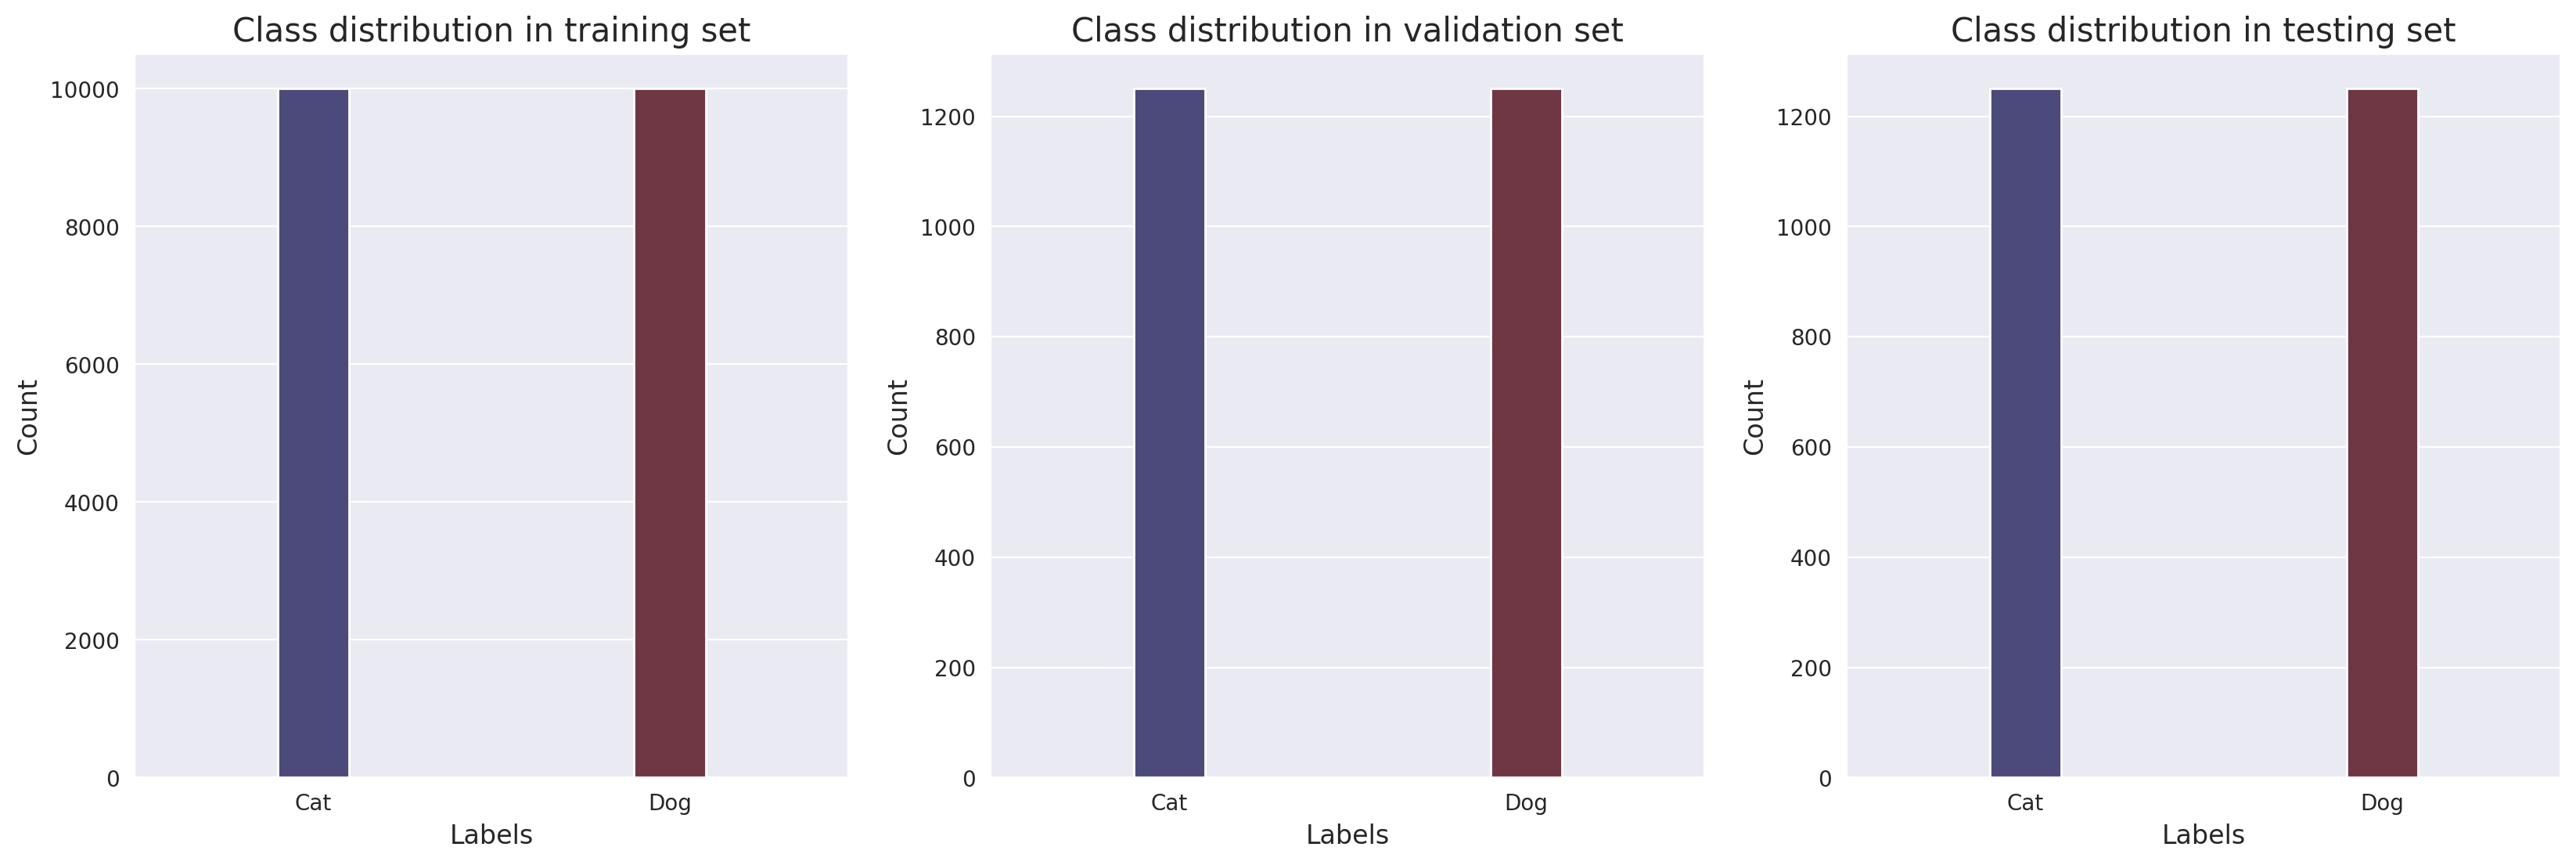

In [10]:
# Train test split using dataframe

labels = ['Cat','Dog']

label1,count1 = np.unique(X_train.label,return_counts=True)
label2,count2 = np.unique(X_val.label,return_counts=True)
label3,count3 = np.unique(X_test.label,return_counts=True)

uni1 = pd.DataFrame(data=count1,index=labels,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=labels,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=labels,columns=['Count3'])


plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire',width=0.2).set_title('Class distribution in training set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index,y='Count2',palette='icefire',width=0.2).set_title('Class distribution in validation set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)


plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',palette='icefire',width=0.2).set_title('Class distribution in testing set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.show()

## Image median

You need to find the median size of image for model building.

In [11]:
image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)]

image_width = []
image_height = []

for image_path in tqdm(image_paths):
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    image_width.append(width)
    image_height.append(height)

median_width = np.median(image_width)
median_height = np.median(image_height)

print('Median size:', median_width,  'X', median_height)

100%|██████████| 25000/25000 [00:50<00:00, 490.38it/s]

Median size: 447.0 X 374.0


# Data preparation

## Parameters for the model

In [12]:
image_size = 370
image_channel = 3 # Because the images are in RGB
batch_size = 64

## Image data generator

In [13]:
# Create image data generator

idg = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

train_idg = idg.flow_from_dataframe(X_train, "/kaggle/working/train",
                                    x_col= "filename",
                                    y_col= "label",
                                    batch_size = batch_size,
                                    class_mode = "binary",
                                    target_size=(image_size,image_size))

val_idg = idg.flow_from_dataframe(X_val, "/kaggle/working/train",
                                  x_col="filename",
                                  y_col="label",
                                  batch_size = batch_size,
                                  class_mode = "binary",
                                  target_size = (image_size,image_size),
                                  shuffle = False)

test_idg = idg.flow_from_dataframe(X_test, "/kaggle/working/train",
                                   x_col= "filename",
                                   y_col= "label",
                                    batch_size = batch_size,
                                    class_mode = "binary",
                                    target_size=(image_size,image_size),
                                   shuffle = False)

Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


# Deep learning model

## VGG16

VGG16 is a Convolutional Neural Network (CNN) that employs a 16-layer architecture, primarily dedicated to image classification.


In [14]:
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(image_size, image_size, image_channel))

for layer in vgg16_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


## Model

This code expands the VGG16 model by introducing layers for data preprocessing and classification. Although the typical choice for the final output is softmax, I've opted for sigmoid due to the dataset's exclusive prediction of a binary class.

In [15]:
flat = tf.keras.layers.Flatten() (vgg16_model.output)
dropout1 = tf.keras.layers.Dropout(0.2, name="Dropout1") (flat)
dense1 = tf.keras.layers.Dense(128, activation="relu") (dropout1)
dropout2 = tf.keras.layers.Dropout(0.2, name="Dropout2")(dense1)
output = tf.keras.layers.Dense(1, activation="sigmoid") (dropout2)

final_model = tf.keras.models.Model(inputs=[vgg16_model.input], outputs=[output])

## Callbacks

I implement two techniques for enhancing neural network training "ReduceLROnPlateau" dynamically adjusts the learning rate, while "EarlyStopping" halts training if validation loss fails to improve, preventing overfitting.

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience=2,
                                            factor=0.5, min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss', patience=5,
                              restore_best_weights=True, verbose=0)

## Compile the model

In [17]:
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Fit the model

In [18]:
history = final_model.fit(train_idg,
                          validation_data=val_idg,
                          batch_size=batch_size,
                          epochs = 20,
                          callbacks=[learning_rate_reduction, early_stoping])

Epoch 1/20
313/313 [==============================] - 309s 893ms/step - loss: 0.4064 - accuracy: 0.9645 - val_loss: 0.1222 - val_accuracy: 0.9792 - lr: 0.0010
Epoch 2/20
313/313 [==============================] - 282s 899ms/step - loss: 0.0461 - accuracy: 0.9851 - val_loss: 0.1126 - val_accuracy: 0.9824 - lr: 0.0010
Epoch 3/20
313/313 [==============================] - 270s 860ms/step - loss: 0.0271 - accuracy: 0.9901 - val_loss: 0.1291 - val_accuracy: 0.9796 - lr: 0.0010
Epoch 4/20
313/313 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9926
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
313/313 [==============================] - 279s 889ms/step - loss: 0.0237 - accuracy: 0.9926 - val_loss: 0.1379 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 5/20
313/313 [==============================] - 267s 854ms/step - loss: 0.0121 - accuracy: 0.9956 - val_loss: 0.1309 - val_accuracy: 0.9844 - lr: 5.0000e-04
Epoch 6/20
313/313 [====================

## Plot the results

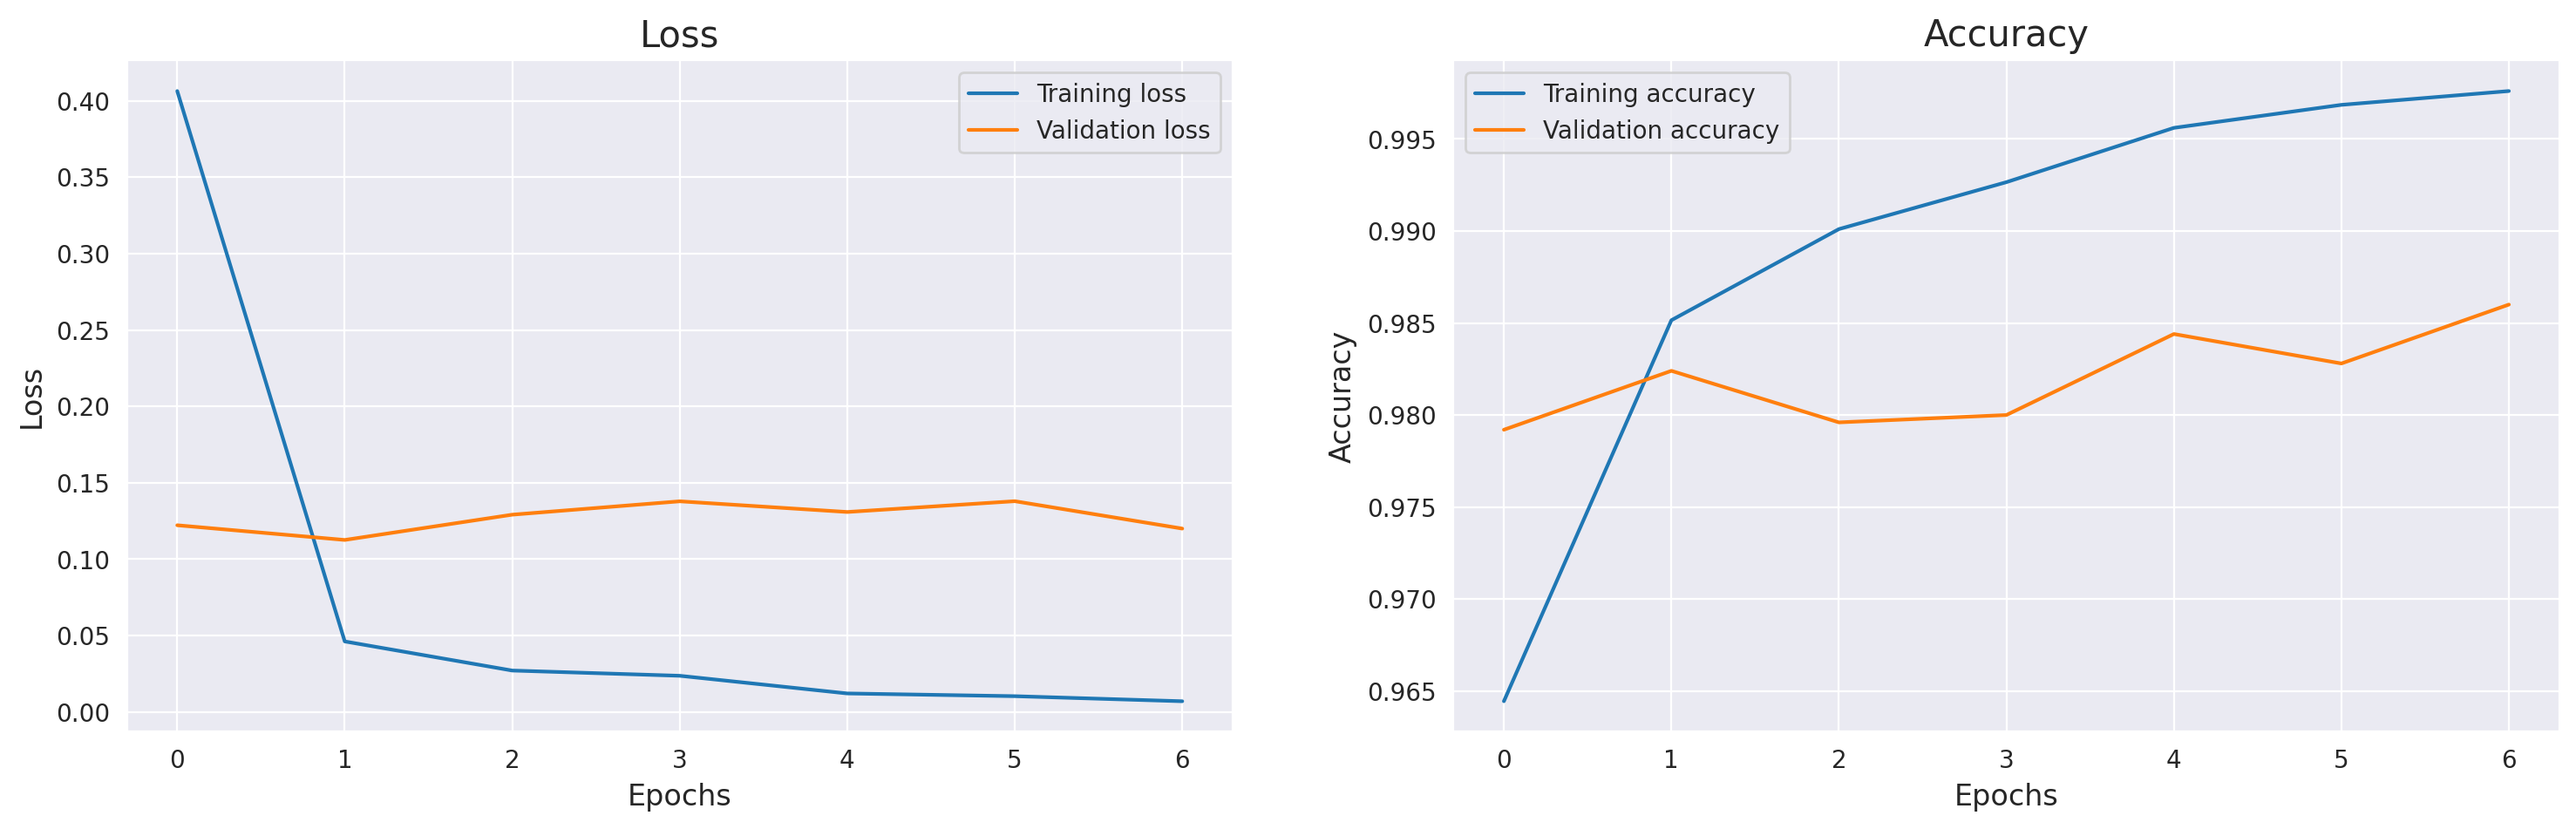

In [19]:
error = pd.DataFrame(history.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'], label='Training loss')
plt.plot(error['val_loss'], label='Validation loss')
plt.legend()

plt.subplot(122)
plt.title('Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'], label='Training accuracy')
plt.plot(error['val_accuracy'], label='Validation accuracy')
plt.legend()

plt.show()

## Evaluation


In [20]:
# Evaluation for the training
loss_train, acc_train = final_model.evaluate(train_idg, batch_size = batch_size, verbose = 1)

print('The accuracy of the model for training data is :', acc_train*100)
print('The Loss of the model for training data is :', loss_train)

313/313 [==============================] - 240s 767ms/step - loss: 0.0137 - accuracy: 0.9959
The accuracy of the model for training data is : 99.59499835968018
The Loss of the model for training data is : 0.013651398941874504


In [21]:
# Evaluation for the test
loss_test ,acc_test = final_model.evaluate(test_idg, batch_size = batch_size, verbose = 1)

print('The accuracy of the model for testing data is :', acc_test*100)
print('The Loss of the model for testing data is :', loss_test)

40/40 [==============================] - 30s 732ms/step - loss: 0.0473 - accuracy: 0.9820
The accuracy of the model for testing data is : 98.19999933242798
The Loss of the model for testing data is : 0.047328416258096695


# Prediction

## Parameters for the prediction

In [22]:
# Prediction using the final model on the test data
result = final_model.predict(test_idg, batch_size=batch_size, verbose=1)

# Rounding off the predictions to the nearest integer (assuming binary classification)
y_pred = np.round(result).astype(int)

# Gathering the true labels from the test data generator
y_true = test_idg.labels

40/40 [==============================] - 29s 737ms/step


## Classification report

In [23]:
labels =['Cat','Dog']
print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

         Cat       0.99      0.98      0.98      1250
         Dog       0.98      0.99      0.98      1250

    accuracy                           0.98      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500



## Confusion matrix

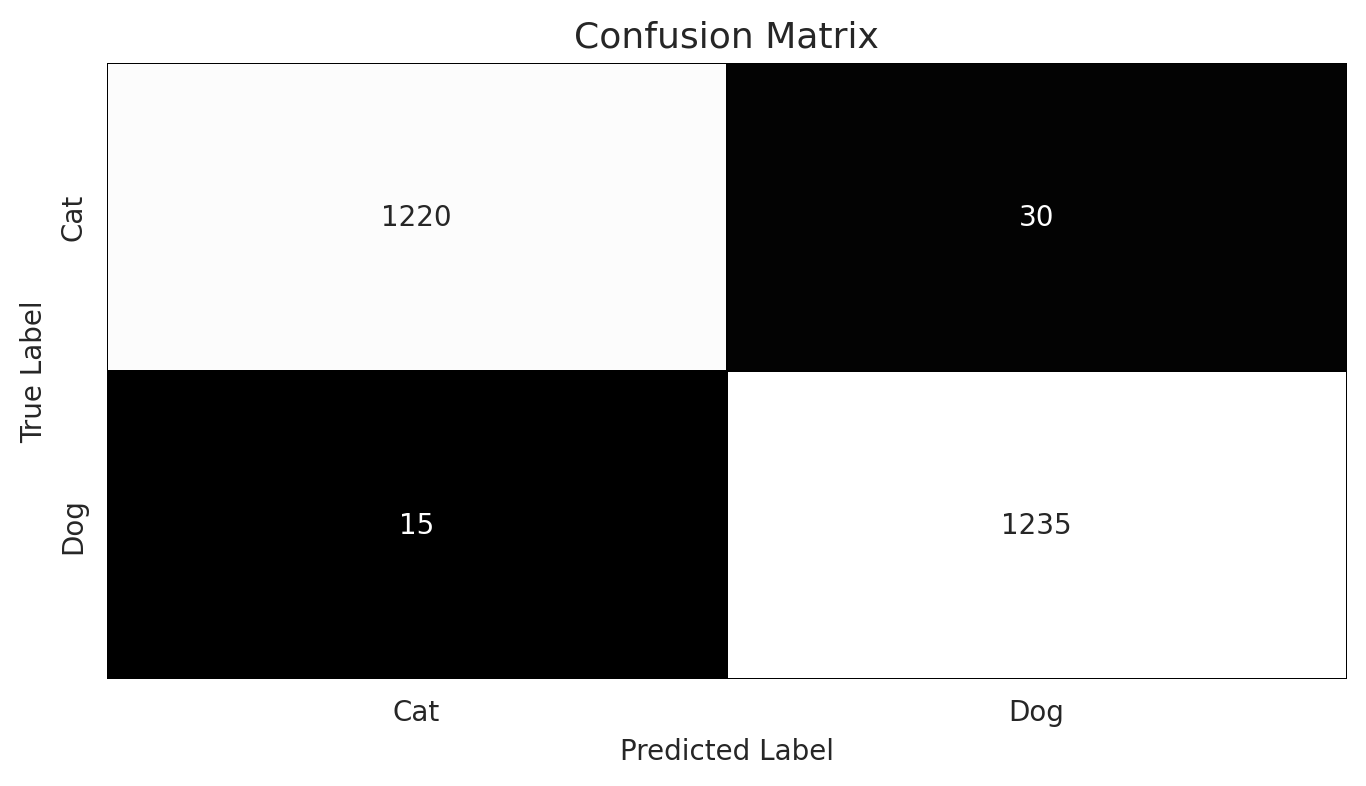

In [24]:
confusion_mtx = confusion_matrix(y_true, y_pred)

f,ax = plt.subplots(figsize = (8,4), dpi=200)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax,cbar=False, xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label",fontsize=10)
plt.ylabel("True Label",fontsize=10)
plt.title("Confusion Matrix",fontsize=13)

plt.show()

## ROC curve

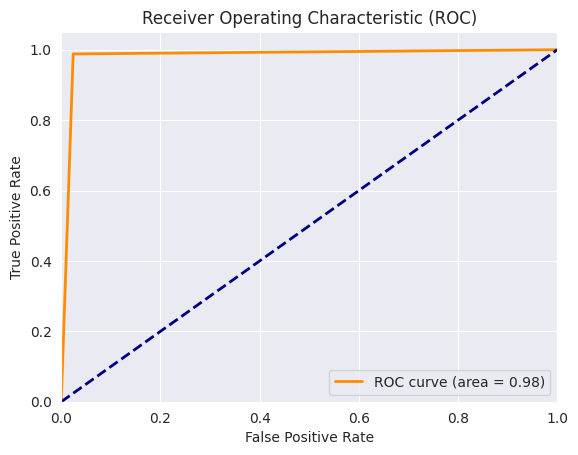

In [25]:
# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)  # y_true is the true labels

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Visualization of our prediction on the test data

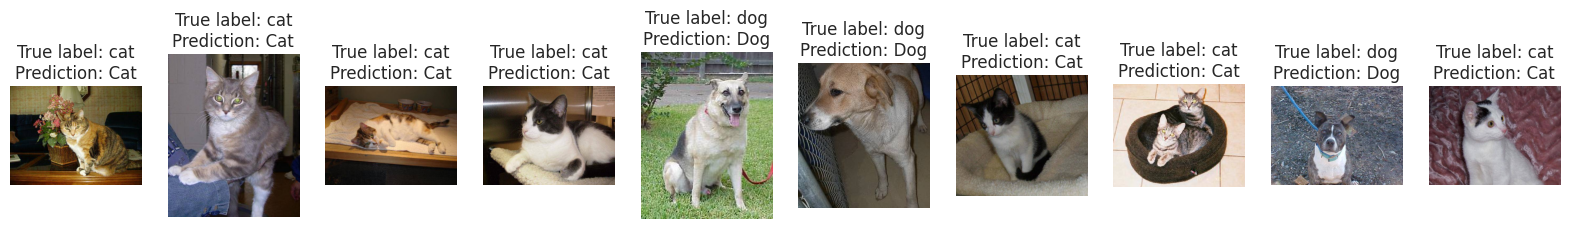

In [31]:
# Create a dataframe with image file names and corresponding predictions
df = pd.DataFrame({
    'filename': X_test['filename'],
    'prediction': y_pred.ravel()  # convert y_pred into a one-dimensional array
})


# Check if the requested number of images is greater than the quantity available in df
num_images_available = len(df)

# Limit the number of images to display to 10 (you can change the value)
num_images_to_display = min(10, num_images_available)

if num_images_available >= num_images_to_display:
    selected_rows = df.sample(num_images_to_display)
    selected_images = selected_rows['filename']
    selected_labels = [data[data['filename'] == img]['label'].values[0] for img in selected_images]
    predictions = selected_rows['prediction']

    # Display the first few images with labels and predictions
    plt.figure(figsize=(20, 8))  # Adjust figure size if necessary
    for i in range(num_images_to_display):
        plt.subplot(1, num_images_to_display, i + 1)
        img = imread('/kaggle/working/train/' + selected_images.iloc[i])
        plt.imshow(img)
        true_label = selected_labels[i]
        predicted_label = "Dog" if predictions.iloc[i] == 1 else "Cat"
        plt.title(f"True label: {true_label}\nPrediction: {predicted_label}")
        plt.axis('off')
    plt.show()
else:
    print("Insufficient available images for the requested display.")

## Test the prediction on a new image

You can utilize a downloadable image from the internet, which includes a cat or a dog, to assess the prediction.

Saving cat.jpg to cat.jpg
Saved file cat.jpg
1/1 [==============================] - 0s 20ms/step


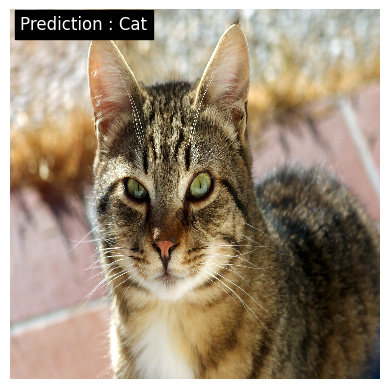

In [30]:
from google.colab import files  # Strangely, the code won't work if you put this library with the others. An error will occur with "files"

# Function to upload an image
def upload():
    uploaded = files.upload()
    for name, data in uploaded.items():
        with open(name, 'wb') as f:
            f.write(data)
            print('Saved file', name)
    return name

# Function to process the uploaded image and make a prediction
def process_and_predict(file_name):
    # Load the image
    image = load_img(file_name, target_size=(image_size, image_size))

    # Preprocess the image
    processed_image = img_to_array(image)
    processed_image = processed_image.reshape((1, processed_image.shape[0], processed_image.shape[1], processed_image.shape[2]))
    processed_image = preprocess_input(processed_image)

    # Make a prediction
    result = final_model.predict(processed_image)

    # Interpret the result
    if result[0][0] == 1:
        prediction = "Dog"
    else:
        prediction = "Cat"

    # Display the uploaded image with the prediction label
    plt.imshow(image)
    plt.axis('off')
    plt.text(10, 20, f"Prediction : {prediction}", fontsize=12, color='white', backgroundcolor='black')
    plt.show()

# Assuming 'final_model' is your pre-trained model
# Upload an image
uploaded_file_name = upload()

# Process the uploaded image and make a prediction
process_and_predict(uploaded_file_name)

# Conclusion

The model isn't flawless and may not achieve perfect accuracy, which could indicate potential overfitting. Furthermore, as the dataset doesn't encompass specific breeds such as Samoyed dogs, the model won't predict those particular types of animals.

Also, I haven't utilized 'test1'. The file lacks labels, yet if you wish to evaluate the model's performance and validate its prediction accuracy, you're welcome to do so.

Finally, if you attempt to input an image that doesn't depict a cat or a dog, the model won't function correctly since it hasn't been trained on data other than dogs and cats.